In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fake_df = pd.read_csv('/content/drive/MyDrive/sem 8/DL/ISOT-Fake.csv')
real_df = pd.read_csv('/content/drive/MyDrive/sem 8/DL/ISOT-True.csv')

Checking for null values 

In [ ]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

In [ ]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [ ]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well. 

In [ ]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [ ]:
fake_df['class'] = 0 
real_df['class'] = 1

Check out the distribution of fake news compare to real news

Text(0, 0.5, '# of News Articles')

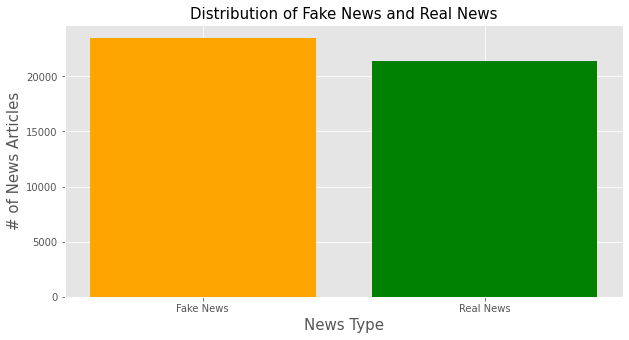

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

In [ ]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [ ]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


Combining the title with the text, it is much easier to process this way. 

In [ ]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing 

In [ ]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [ ]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data. 

In [ ]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article 

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=300)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=300)

In [ ]:
x_train_ = X_train.copy()
x_test_ = X_test.copy()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Building the RNN.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Conv1D(128,5),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 32)          320000    
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         20608     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 lstm_17 (LSTM)              (None, 32)                20608     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 361,249
Trainable params: 361,249
Non-trainable params: 0
________________________________________________

We are going to use early stop, which stops when the validation loss no longer improve.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1078/1078 [==============================] - 92s 84ms/step - loss: 0.3933 - accuracy: 0.8291 - val_loss: 0.1899 - val_accuracy: 0.9457
Epoch 2/10
1078/1078 [==============================] - 97s 90ms/step - loss: 0.1453 - accuracy: 0.9593 - val_loss: 0.1100 - val_accuracy: 0.9655
Epoch 3/10
1078/1078 [==============================] - 95s 88ms/step - loss: 0.0983 - accuracy: 0.9712 - val_loss: 0.0889 - val_accuracy: 0.9705
Epoch 4/10
1078/1078 [==============================] - 95s 88ms/step - loss: 0.1952 - accuracy: 0.9427 - val_loss: 0.0937 - val_accuracy: 0.9697
Epoch 5/10
1078/1078 [==============================] - 95s 88ms/step - loss: 0.0667 - accuracy: 0.9829 - val_loss: 0.0635 - val_accuracy: 0.9825
Epoch 6/10
1078/1078 [==============================] - 97s 90ms/step - loss: 0.0463 - accuracy: 0.9895 - val_loss: 0.0584 - val_accuracy: 0.9833
Epoch 7/10
1078/1078 [==============================] - 95s 88ms/step - loss: 0.0380 - accuracy: 0.9919 - val_loss: 0.0596 - val_accura

Visualize our training over time 

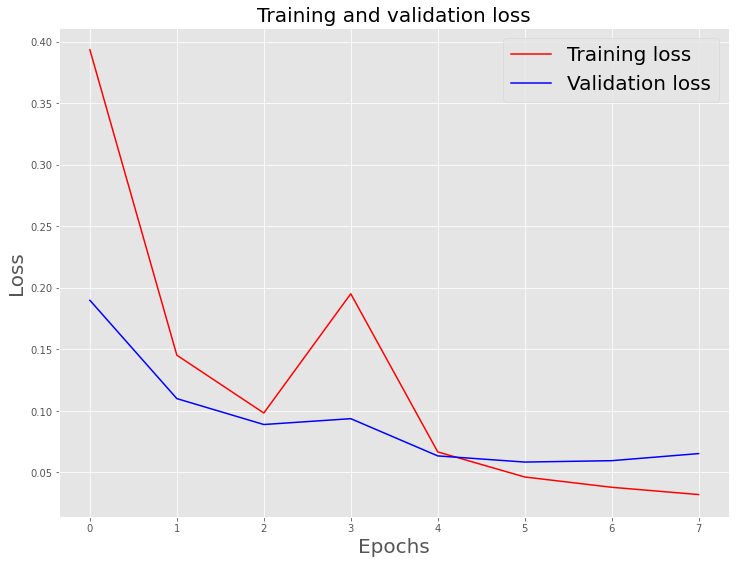

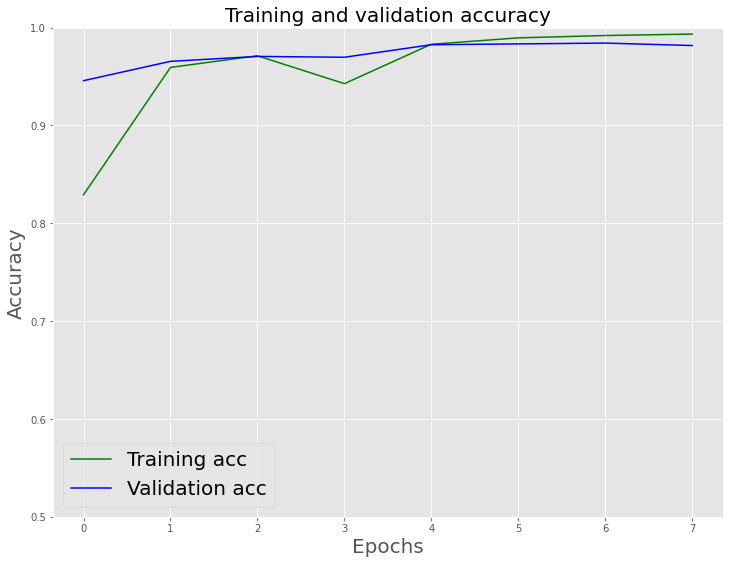

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set 

In [ ]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 6s 22ms/step - loss: 0.0644 - accuracy: 0.9815


[0.06440802663564682, 0.9815144538879395]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 6s 19ms/step


In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9815144766146994
Precision on testing set: 0.9821676702176934
Recall on testing set: 0.979445727482679


Confusion matrix 

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

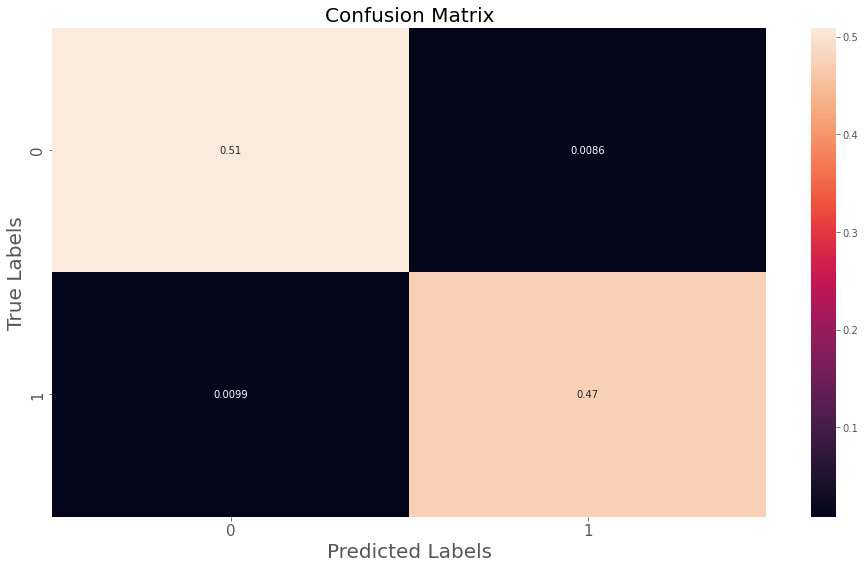

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

Saves the weights for visualiation

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [ ]:
type(x_train_[0])

list

In [ ]:
model = LogisticRegression()
model.fit(x_train_, y_train)
preds = model.predict(x_test_)
acc = accuracy_score(preds, y_test)
prec = precision_score(preds, y_test)
rec = recall_score(preds, y_test)
print(acc, prec, rec)

0.5981069042316258 0.5217693376563224 0.5933631814590467


In [ ]:
model = KNeighborsClassifier()
model.fit(x_train_, y_train)
preds = model.predict(x_test_)
acc = accuracy_score(preds, y_test)
prec = precision_score(preds, y_test)
rec = recall_score(preds, y_test)
print(acc, prec, rec)

0.5545657015590201 0.7561371005094951 0.5255956213779781


In [ ]:
model = AdaBoostClassifier()
model.fit(x_train_, y_train)
preds = model.predict(x_test_)
acc = accuracy_score(preds, y_test)
prec = precision_score(preds, y_test)
rec = recall_score(preds, y_test)
print(acc, prec, rec)

0.7632516703786192 0.7672533580361278 0.7471808750563825


In [ ]:
model = RandomForestClassifier()
model.fit(x_train_, y_train)
preds = model.predict(x_test_)
acc = accuracy_score(preds, y_test)
prec = precision_score(preds, y_test)
rec = recall_score(preds, y_test)
print(acc, prec, rec)

0.8789532293986637 0.8686892079666513 0.8782486537110747


In [ ]:
model = BaggingClassifier()
model.fit(x_train_, y_train)
preds = model.predict(x_test_)
acc = accuracy_score(preds, y_test)
prec = precision_score(preds, y_test)
rec = recall_score(preds, y_test)
print(acc, prec, rec)

0.8910913140311804 0.8557202408522464 0.9123456790123456
